In [1]:
%%capture
import json
import os
from IPython.display import Javascript

os.environ['R_HOME'] = 'C:/Users/erneilso/Documents/R/R-4.1.1/'
%load_ext rpy2.ipython

%run -i ./MDT_Functions.py


C:\Users\erneilso\OneDrive - NRCan RNCan\Collaborations\RC Steering Committee\MonitoringDecisionTool
The study area has (417996.4415538451, 795945.195356781, 1126884.4543278955, 1581144.825542611). 
It has 76 rows and 91 columns.

------------------
Finished inputing Use vars: ['elevation', 'water_proximity']

------------------
Used the inputted rasters to simulate the spatial probability of use across study area.

------------------
Converting use into occupancy. What is the true proportion of the area that is occupied (number between 0 and 1)?0.5
There are 3458 occupied pixels (86450.0 km occupied area). This leads to an instantaneous probability of detection in any cell for one, randomly moving, individual of 0.0003

------------------
Simulate a population within the occupied cells using a population density. What is the density of individuals per km2 (0.001 - 1)?0.05

With a density of 0.05 individuals per pixel across all occupied pixels, the total population is 4322.5. This giv

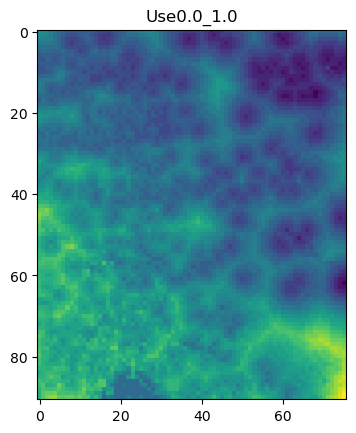

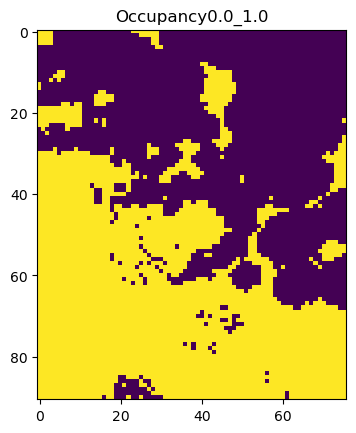

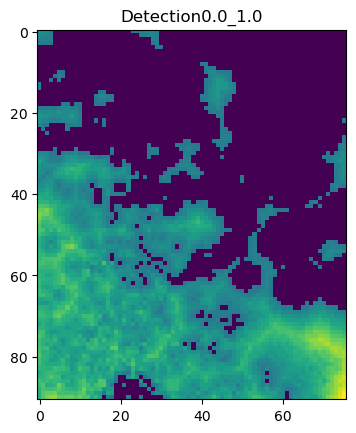

In [2]:
### INPUT DATA
inputSpatial()

# SIMULATE RESPONSE
simulateReponse()

# ## simulate resposne
# Javascript("Jupyter.notebook.execute_cells([2])")

In [4]:
## SIMULATE OCCUANPCY DATA
simulateOccupancyData()

Enter the configuration of cameras 
 (1) Systematic
 (2) Random
 (3) Stratigied Random 
2
------------------
Enter the number of site scenarios.3
Enter the max number of cameras.100
Enter the min number of cameras.50
Enter the number of duration scenarios.10
Enter the max duration of deployments (weeks).20
Enter the min duration of deployments (weeks).2


In [5]:
%R -i cwd
%R -i trueOcc
%R -i popPX
%R -i N
%R -i meanDetection

Javascript("Jupyter.notebook.execute_cells([4])")


<IPython.core.display.Javascript object>

In [6]:
%%R

library(unmarked)

OccOutTab = data.frame(CamN = NA, IntervalsN = NA, Response = NA, Estimate = NA, SE = NA, Bias = NA)
scenCount = 0

dhScenDirs = list.dirs(paste0(cwd,'/Data/DetectionHistories'),recursive = FALSE)  
# print(dhScenDirs)

for (dir in dhScenDirs){    

    scenI = unlist(strsplit(dir,"/"))
    scen = scenI[length(scenI)]
    scen = unlist(strsplit(scen,"_"))
    CameraNumber = scen[1]
    VisitsNumber = scen[2]

    dhScens = list.files(dir,pattern="\\.csv$")
    
    for (scen in dhScens){
        
        dh = read.csv(paste0(dir,"/",scen),header=T)

        ## fit model to scenario data
        umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
        fm <- occu(~1 ~1, umf) # fit a model

        ## model outputs
        psiTab = predict(fm, type="state",newdata=data.frame(1))
        psi = psiTab$Predicted
        psiSE = psiTab$SE
        psiBias = psi - trueOcc
        pTab = predict(fm, type="det",newdata=data.frame(1))
        p = pTab$Predicted
        pSE = pTab$SE
        pBias = p - meanDetection
        
        ## occupancy info
        scenCount = scenCount + 1
        OccOutTab[scenCount,"CamN"] = CameraNumber
        OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
        OccOutTab[scenCount,"Response"] = "psi"
        OccOutTab[scenCount,"Estimate"] = psi
        OccOutTab[scenCount,"SE"] = psiSE
        OccOutTab[scenCount,"Bias"] = psiBias
        
        ## detection info
        scenCount = scenCount + 1
        OccOutTab[scenCount,"CamN"] = CameraNumber
        OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
        OccOutTab[scenCount,"Response"] = "p"
        OccOutTab[scenCount,"Estimate"] = p
        OccOutTab[scenCount,"SE"] = pSE
        OccOutTab[scenCount,"Bias"] = pBias

        }
    }


print("Fit occupancy models to all deteciton histories.")
# print(OccOutTab)

[1] "Fit occupancy models to all deteciton histories."


In addition: Warning message:
package 'unmarked' was built under R version 4.1.3 


-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.1     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.1     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
`summarise()` has grouped output by 'CamN', 'IntervalsN'. You can override using the `.groups` argument.
# A tibble: 36 x 18
# Groups:   CamN, IntervalsN [18]
   CamN  IntervalsN Response     N meanEstimate  sdEstimate  seEstimate
   <fct> <chr>      <chr>    <int>        <dbl>       <dbl>       <dbl>
 1 51    10         p           50        0.561 0.0335      0.00473    
 2 51    10         p

Loading required package: tidyverse
In addition: Warning messages:
1: package 'tidyverse' was built under R version 4.1.3 
2: package 'ggplot2' was built under R version 4.1.3 
3: package 'tibble' was built under R version 4.1.3 
4: package 'tidyr' was built under R version 4.1.3 
5: package 'readr' was built under R version 4.1.3 
6: package 'purrr' was built under R version 4.1.3 
7: package 'dplyr' was built under R version 4.1.3 
8: package 'stringr' was built under R version 4.1.3 
9: package 'forcats' was built under R version 4.1.3 
10: package 'lubridate' was built under R version 4.1.3 


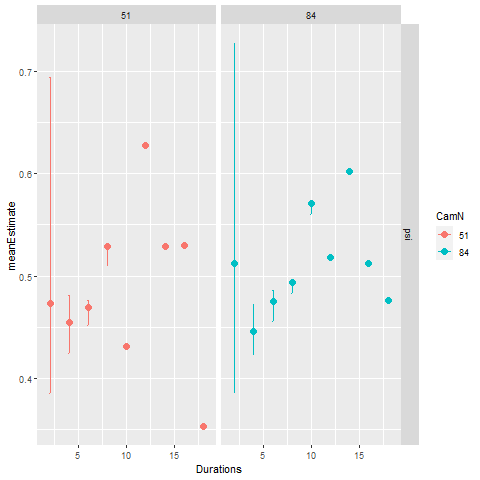

In [7]:
%%R

require(tidyverse)
library(ggplot2)

SumTab = OccOutTab %>%
    group_by(CamN, IntervalsN, Response) %>%
    summarise(
        N = length(Estimate),
        
        meanEstimate = mean(Estimate),
        sdEstimate = sd(Estimate),
        seEstimate   = sdEstimate / sqrt(N),
        UpperCI_Est = quantile(Estimate,probs = 0.975),
        LowerCI_Est = quantile(Estimate,probs = 0.025),
        
        meanSE = mean(SE),
        sdSE = sd(SE),
        seSE   = sdSE / sqrt(N),
        
        meanBias = mean(Bias),
        sdBias = sd(Bias),
        seBias   = sdBias / sqrt(N),
        UpperCI_Bias = quantile(Bias,probs = 0.975),
        LowerCI_Bias = quantile(Bias,probs = 0.025)) %>%

    mutate(CamN = as.factor(CamN),
           Durations = as.numeric(IntervalsN))


print(SumTab)
print(meanDetection)


pd = position_dodge(1)
dummy2 <- c(meanDetection,trueOcc)
print(dummy2)
SumTab %>%
    filter(Response == "psi")%>%
    ggplot(
        #aes(x=Durations, y=meanEstimate,ymin=meanEstimate-seEstimate, ymax=meanEstimate+seEstimate, colour=CamN)) + 
        aes(x=Durations, y=meanEstimate,ymin=UpperCI_Est, ymax=LowerCI_Est, colour=CamN)) +
        geom_errorbar(width=0.1,position = pd)+
        geom_point(size = 3, position = pd) +        
        facet_grid(Response~CamN)
#         geom_hline(data = dummy2) +
#         ylim(0,1)+
#         theme(panel.border = element_blank(), panel.grid.major = element_blank(),
#               axis.line = element_line(colour = "black"))
# #         geom_abline(size=0.5,intercept = trueOcc, slope=0)
        
   

In [ ]:
%whos